In [1]:
from itertools import combinations
import numpy as np
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from copy import deepcopy
from icecream import ic

## Simple Test Problem

In [2]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('test_problems/test_problem.npy')
test_problem.shape

(20, 20)

In [3]:
problem = np.load('test_problems/problem_g_50.npy')

In [4]:
@dataclass
class Solution:
    sequence: np.ndarray
    fitness: float

In [5]:
class TSPSolver:
    """
    Hill climber solution for solving TSP problem
    """

    def __init__(self, cost_matrix, sol: np.ndarray = None):
        self.cost_matrix = cost_matrix
        self.solution_size = cost_matrix.shape[0]
        if sol is None:
            sol = self._make_greedy_solution()
        self.sol = sol
        

    def _make_greedy_solution(self, eps: float = 0.1):
        """
        Generate greedy solution, with probability eps choose instead a random destination
        """
        solution = -np.ones(self.solution_size, dtype=int)
        initial = np.random.randint(0, self.solution_size-1)

        solution[0] = initial


        for pos in range(1, self.solution_size):
            cur = int(solution[pos-1])
            row = self.cost_matrix[cur, :].copy()
            visited = solution[:pos].astype(int)
            row[visited] = np.inf

            if np.random.rand() < eps:
                # Choose randomly
                choices = np.where(row < np.inf)[0]
                next_step = int(np.random.choice(choices))
            else:
                # Choose among lowest next stop costs
                choices = choices = np.where(row == row.min())[0]
                next_step = int(np.random.choice(choices))
            solution[pos] = next_step
            solution = np.array(solution)
        return self._new_solution(solution)
    
    def _new_solution(self, sequence: np.ndarray):
        return Solution(sequence, self._compute_fitness(sequence))
    
    def _compute_fitness(self, sequence: np.ndarray) -> float:
        cost = 0
        from_loc = sequence[0]
        for i in range(sequence.shape[0]-1):
            to_loc = sequence[i+1]
            cost += self.cost_matrix[from_loc, to_loc]
            from_loc = to_loc
        cost+=self.cost_matrix[from_loc, sequence[0]]   #Count cycle closure
        return cost
    
    def hc_solve(self, max_iter: int = 1000):
        """
        Hill climbing algorithm to solve TSP
        """
        current_solution = deepcopy(self.sol)
        best_solution = deepcopy(current_solution)

        current_history = [current_solution.fitness]
        best_history = [best_solution.fitness]

        for iteration in range(max_iter):
            # Tweak solution
            i,j = np.random.choice(self.solution_size, size=2, replace=False)
            new_sequence = current_solution.sequence.copy()
            new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
            new_solution = self._new_solution(new_sequence)
            # If new solution is better, keep it
            if new_solution.fitness <= current_solution.fitness:
                current_solution = new_solution
                # Update best solution found
                if current_solution.fitness < best_solution.fitness:
                    best_solution = current_solution
            elif np.log(np.random.random()) < (current_solution.fitness - new_solution.fitness) / (0.1*(max_iter - iteration)/max_iter):
                current_solution = new_solution
            # Store history
            current_history.append(current_solution.fitness)
            best_history.append(best_solution.fitness)
        self.best_solution = deepcopy(best_solution)

        return best_solution, current_history, best_history



In [6]:
np.random.seed(42)
solver = TSPSolver(problem)
hc_best_sol, hc_history, hc_best_history = solver.hc_solve(max_iter=50000)

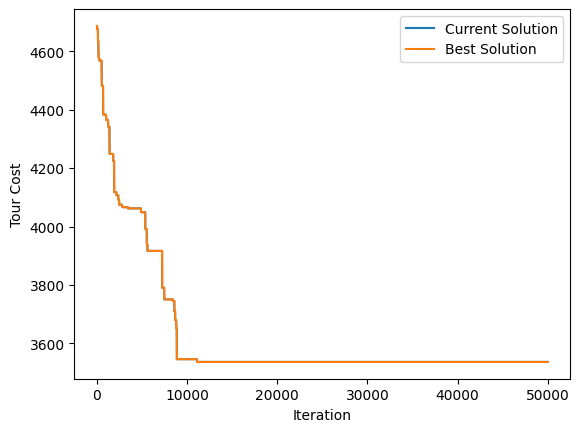

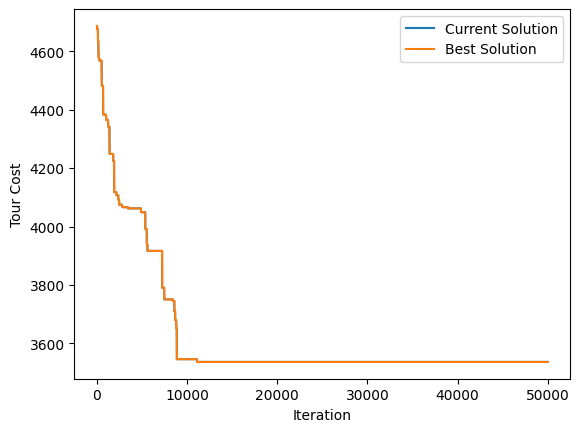

ic| hc_best_sol.fitness: np.float64| hc_best_sol.fitness: np.float64(3536.3546530818085(3536.3546530818085)
)


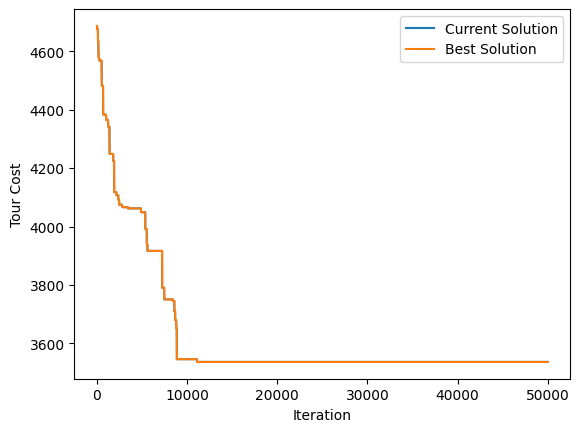

ic| hc_best_sol.fitness: np.float64| hc_best_sol.fitness: np.float64(3536.3546530818085(3536.3546530818085)
)


np.float64(3536.3546530818085)

In [7]:
plt.plot(hc_history, label='Current Solution')
plt.plot(hc_best_history, label='Best Solution')
plt.xlabel('Iteration')
plt.ylabel('Tour Cost')
plt.legend()
plt.show()
ic(hc_best_sol.fitness)

In [8]:
class TSPECSolver:
    """
    Evolutionary strategy solution for solving TSP problem
    """

    def __init__(self, cost_matrix, population_size: int = 100, offspring_size: int = 50, mutation_rate: float = 0.01, greedy_initial_solutions: bool = True, tau: int=20):
        self.cost_matrix = cost_matrix
        self.solution_size = cost_matrix.shape[0]
        self.population_size = population_size
        self.offspring_size = offspring_size
        self.mutation_rate = mutation_rate
        self.cost_simmetry = (cost_matrix.T == cost_matrix).all()
        self.tau = tau

        if greedy_initial_solutions:
            self.population = [self._make_greedy_solution(np.random.rand()) for _ in range(self.population_size)]
        else:
            self.population = [self._make_random_solution() for _ in range(self.population_size)]
        self.population.sort(key=lambda sol: sol.fitness)   #Keep population sorted by fitness

    def _make_random_solution(self):
        sequence = np.random.permutation(self.solution_size)
        return self._new_solution(sequence)
        

    def _make_greedy_solution(self, eps: float = 0.1):
        """
        Generate greedy solution, with probability eps choose instead a random destination
        """
        solution = -np.ones(self.solution_size, dtype=int)
        initial = np.random.randint(0, self.solution_size-1)

        solution[0] = initial


        for pos in range(1, self.solution_size):
            cur = int(solution[pos-1])
            row = self.cost_matrix[cur, :].copy()
            visited = solution[:pos].astype(int)
            row[visited] = np.inf

            if np.random.rand() < eps:
                # Choose randomly
                choices = np.where(row < np.inf)[0]
                next_step = int(np.random.choice(choices))
            else:
                # Choose among lowest next stop costs
                choices = choices = np.where(row == row.min())[0]
                # If multiple minimums, then choose a random one
                next_step = int(np.random.choice(choices))
            solution[pos] = next_step
        return self._new_solution(solution)
    
    def _new_solution(self, sequence: np.ndarray):
        return Solution(sequence, self._compute_fitness(sequence))
    
    def _compute_fitness(self, sequence: np.ndarray) -> float:
        seq = np.asarray(sequence, dtype=int)
        if seq.size == 0:
            return 0.0
        
        next_idx = np.roll(seq, -1)
        return float(np.sum(self.cost_matrix[seq, next_idx]))
    
    def _selection(self, tau: int = 5) -> list[list[Solution]]:
        """
        Select parents using tournament selection
        """
        selected = []
        for _ in range(self.offspring_size):
            current = []
            for _ in range(2):  #Select two parents
                competitors = np.random.choice(self.population, size=tau, replace=False)
                winner = min(competitors, key=lambda sol: sol.fitness)
                current.append(winner)
            selected.append(current)
        return selected
    
    def _selection_better(self, tau: int = 5) -> list[list[Solution]]:
        """
        Select parents using tournament selection (numpy optimized)
        """
        pop_n = len(self.population)
        if tau > pop_n:
            tau = pop_n

        fitness = np.array([sol.fitness for sol in self.population])
        indices = np.arange(pop_n)

        # Select tau competitors for each parent of each offspring
        competitors = np.stack([
            np.random.choice(indices, size=(self.offspring_size, tau), replace=True)
            for _ in range(2)  #Select two parents
        ], axis=1)  # Shape: (offspring_size, 2, tau)

        # Compute fitness of each competitor
        competitors_fitness = fitness[competitors]  # Shape: (offspring_size, 2, tau)

        # Select the best competitor for each parent of each offspring
        winners_indices = np.argmin(competitors_fitness, axis=2)  # Shape: (offspring_size, 2)


        offspring_idx = np.arange(self.offspring_size)[:, np.newaxis]       # Shape: (offspring_size, 1)
        parent_idx = np.arange(2)[np.newaxis, :]                            # Shape: (1, 2)
        winners = competitors[offspring_idx, parent_idx, winners_indices]   # Shape: (offspring_size, 2)

        selected = [
            [self.population[winner] for winner in pair]
            for pair in winners
        ]
        return selected



    
    def _crossover(self, p1: Solution, p2: Solution) -> Solution:
        """
        Pick 2 crossover points and exchange the segments between parents
        Then fill the remaining cities from the other parent in order
        """

        cx1, cx2 = np.sort(np.random.choice(self.solution_size, size=2, replace=False))

        child_sequence = -np.ones(self.solution_size, dtype=int)
        # Copy segment from first parent
        child_sequence[cx1:cx2] = p1.sequence[cx1:cx2]

        child_cities = set(child_sequence[cx1:cx2].tolist())

        # Fill remaining cities from second parent
        current_pos = cx2 % self.solution_size
        for city in p2.sequence:
            if city not in child_cities:
                child_sequence[current_pos] = city
                child_cities.add(city)
                current_pos = (current_pos + 1) % self.solution_size
        return self._new_solution(child_sequence)
    
    def _mutate(self, solution: Solution) -> Solution:
        """
        Mutate solution by swapping two cities with probability mutation_rate
        """
        new_sequence = solution.sequence.copy()
        for i in range(self.solution_size):
            if np.random.rand() < self.mutation_rate:
                j = np.random.randint(0, self.solution_size)
                new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
        return self._new_solution(new_sequence)
                

    def es_solve(self, max_iter: int = 1000):
        """
        Evolution Strategy algorithm to solve TSP
        """
        best_solution = min(self.population, key=lambda sol: sol.fitness)

        history = [best_solution.fitness]
        best_history = [best_solution.fitness]

        for iteration in range(max_iter):
            #Get parents for offspring generation
            parents = self._selection_better(tau=self.tau)
            #Generate offspring from combining parents
            offspring = [self._crossover(p1, p2) for p1, p2 in parents]
            #Mutate some offspring
            final_offspring = [self._mutate(o) if np.random.rand() < self.mutation_rate else o for o in offspring]
            # Select next generation
            combined = self.population + final_offspring
            # combined = final_offspring
            combined.sort(key=lambda sol: sol.fitness)
            # Keep best POP_SIZE individuals
            self.population = combined[:self.population_size]

            if self.population[0].fitness < best_solution.fitness:
                best_solution = deepcopy(self.population[0])

            history.append(self.population[0].fitness)
            best_history.append(best_solution.fitness)


        return best_solution, best_history, history


ic| hc_best_sol.fitness: 4183.427811492184
| hc_best_sol.fitness: 4183.427811492184


ic| hc_best_sol.fitness: 4183.427811492184
| hc_best_sol.fitness: 4183.427811492184


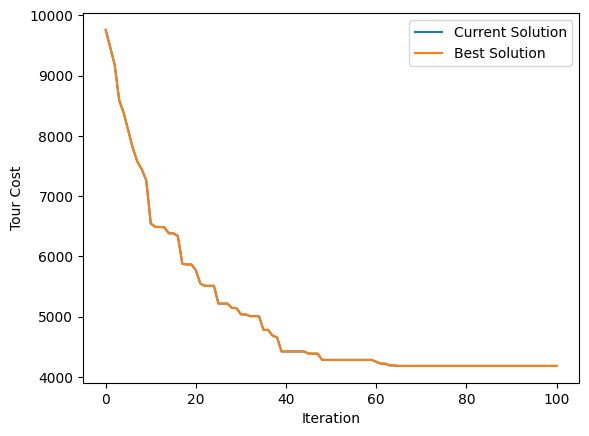

In [9]:
np.random.seed(42)

solver = TSPECSolver(problem, greedy_initial_solutions=False)
hc_best_sol, hc_best_history, hc_history = solver.es_solve(max_iter=100)
ic(hc_best_sol.fitness)

plt.plot(hc_history, label='Current Solution')
plt.plot(hc_best_history, label='Best Solution')
plt.xlabel('Iteration')
plt.ylabel('Tour Cost')
plt.legend()
plt.show()



In [10]:
np.unique(hc_best_sol.sequence).shape[0] == hc_best_sol.sequence.shape[0]

True

In [ ]:
import os
from joblib import Parallel, delayed

results = {}

# mutations = [0.01, 0.05, 0.1]
# populations = [50, 100, 200]
# offsprings = [25, 50, 100]
# greedy = [False, True]

mutations = [0.01]
populations = [50]
offsprings = [25]
greedy = [True]

def _ec_task(current_problem, mutation, population, offspring, use_greedy):
    np.random.seed(42)
    ec_solver = TSPECSolver(current_problem, 
                            population_size=population, offspring_size=offspring, 
                            mutation_rate=mutation, greedy_initial_solutions=use_greedy)
    ec_best_sol, ec_best_history, ec_history = ec_solver.es_solve(max_iter=250)

    return {
        'best_fitness': float(ec_best_sol.fitness),
        'best_sequence': ec_best_sol.sequence.tolist(),
        'best_history': [float(x) for x in ec_best_history],
        'current_history': [float(x) for x in ec_history],
        'params': {
            'greedy_initial': bool(use_greedy),
            'population': int(population),
            'offspring': int(offspring),
            'mutation': float(mutation)
        }
    }

def _hc_task(current_problem):
    np.random.seed(42)
    hc_solver = TSPSolver(current_problem)
    hc_best_sol, hc_best_history, hc_history = hc_solver.hc_solve(max_iter=10000)

    return {
        'best_fitness': float(hc_best_sol.fitness),
        'best_sequence': hc_best_sol.sequence.tolist(),
        'best_history': [float(x) for x in hc_best_history],
        'current_history': [float(x) for x in hc_history],
        'params': {'greedy_initial': True}
    }

# reuse _ec_task and _hc_task already defined above (must be top-level)
for filename in os.listdir('test_problems'):
    if not (filename.startswith('problem') and filename.endswith('.npy')):
        continue

    if not (filename.startswith('problem_g_10')):
        continue
    current_problem = np.load(os.path.join('test_problems', filename))

    # Run hill-climber serially (keeps deterministic seed per run)
    np.random.seed(42)
    hc_entry = _hc_task(current_problem)
    results[filename] = {'hc': hc_entry}

    # Build EC parameter combinations for this problem
    param_combinations = [
        (current_problem, mutation, population, offspring, use_greedy)
        for mutation in mutations
        for population in populations
        for offspring in offsprings
        for use_greedy in greedy
    ]

    # Execute EC tasks in parallel (joblib uses cloudpickle -> safer in notebooks)
    try:
        ec_entries = Parallel(n_jobs=-1, backend='loky')(
            delayed(_ec_task)(*params) for params in param_combinations
        )
    except Exception as e:
        print(f"Parallel EC failed for {filename}: {e}")
        ec_entries = []
    results[filename]['ec'] = ec_entries

# Save single JSON with histories (compact lists on one line; compress best_history with run-length encoding)
def rle_compress(vals):
    """Run-length encode a list of scalars -> list of [value, count]."""
    if not vals:
        return []
    out = []
    cur = vals[0]
    cnt = 1
    for v in vals[1:]:
        if v == cur:
            cnt += 1
        else:
            out.append([float(cur), cnt])
            cur = v
            cnt = 1
    out.append([float(cur), cnt])
    return out

def compact_preprocess(o):
    """Traverse results and replace 'best_history' lists with RLE compressed lists (keeps other data)."""
    if isinstance(o, dict):
        return {k: compact_preprocess(v) for k, v in o.items()}
    if isinstance(o, list):
        return [compact_preprocess(v) for v in o]
    return o

with open('solutions_summary.json', 'w') as f:
    json.dump(compact_preprocess(results), f, indent=2)

